* reward function: with coefficient
* accuracy estimation: with predictor
* next item sampling: with random_choice
* input to lstm: tokens expanded
* data_x: without 0-steps

Tokens expanded
* lstm input shape: (5, 6) 
* 5: no. of layers, 6: layer infos
* input to predict: (1, 5, 6)
* predicted output shape: (1, 5, 382) return_sequences=True
* predicts all token layers at once

In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import scipy.stats as stats
import math
import tensorflow as tf
import itertools

In [2]:
baseline = 0.7
loss_alpha = 0.9
# rnn_lr = 0.01 
# rnn_decay = 0.1
no_of_nas_epochs = 30
no_of_samples_per_epoch = 20
max_no_of_layers = 6
rnn_dim = 382
rnn_train_epochs = 32
search_space_len = 382
search_space = np.linspace(1,search_space_len,search_space_len)
rew_coef = 5
no_of_layer_params = 6

In [3]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(search_space, prob[i])
        axs[i].axis('off')    
    plt.show()

In [4]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    seq_hot = keras.utils.to_categorical(sequence[:-1], num_classes=search_space_len+1)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [5]:
def discount_reward(rewards):
    discounted_reward = []
    for t in range(len(rewards)):
        dis_reward = 0
        for i, r in enumerate(rewards[t:]):
            dis_reward = loss_alpha**(i-t) * r
        discounted_reward.append(dis_reward)
    discounted_reward = tf.stack(discounted_reward)
    if len(rewards) > 1:
        discounted_reward = (discounted_reward - K.mean(discounted_reward)) / K.std(discounted_reward)
    return discounted_reward

In [6]:
def reinforce(y_true, y_pred):
    rewards = rew_coef * (data_acc - baseline)
    discounted_rewards = discount_reward(rewards)
    y_pred = K.clip(y_pred, 1e-36, 1e36)
    loss = - K.log(y_pred) * discounted_rewards[:, None]
    return loss

In [7]:
def expand_token(sequence):
    ranges = {
        "nodes": [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
        "layers": [1, 2],  # 1:"Conv2D", 2:"DepthwiseConv2D", 3:"Dense", 4:"dropout", 5:"softmax"
        "filters": [8, 16, 24, 32, 40],
        "paddings": [1, 2],  # 1:"valid", 2:"same"
        "activations": [1, 2],  # 1:"sigmoid", 2:"relu"
        "kernel_sizes": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
        "strides": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
        }
    cnn_params = list(itertools.product(*[ranges["layers"], ranges["filters"], ranges["kernel_sizes"], ranges["strides"], ranges["paddings"], 
                                          ranges["activations"]]))
    dense_params = list(itertools.product(*[[3], [0], [0], [0], ranges["nodes"], ranges["activations"]]))
    last_params = [[4, 2, 0, 0, 0, 0], [5, 2, 0, 0, 0, 0]]  # dropout 0.2, softmax 2
    dictionary = cnn_params + dense_params + last_params
    expanded = [dictionary[i-1] for i in sequence]
    return expanded

In [8]:
# model = None
# main_input = keras.engine.input_layer.Input(shape=(max_no_of_layers-1, no_of_layer_params), batch_shape=None, name="main_input")
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# main_output = keras.layers.Dense(len(search_space), activation="softmax", name="main_output")(x)
# model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [9]:
model = None
main_input = keras.engine.input_layer.Input(shape=(max_no_of_layers-1, no_of_layer_params), batch_shape=None, name="main_input")
x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
main_output = keras.layers.Softmax(name="main_output", axis=-1)(x)
model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [10]:
# model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam(lr=rnn_lr, decay=rnn_decay, clipnorm=1.0))
model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam())

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 5, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 382)            594392    
_________________________________________________________________
main_output (Softmax)        (None, 5, 382)            0         
Total params: 594,392
Trainable params: 594,392
Non-trainable params: 0
_________________________________________________________________


In [12]:
# keras.utils.plot_model(model, "lstm.png", show_shapes=True)

NAS epoch 1
Epoch average accuracy (20 sequences): 0.647


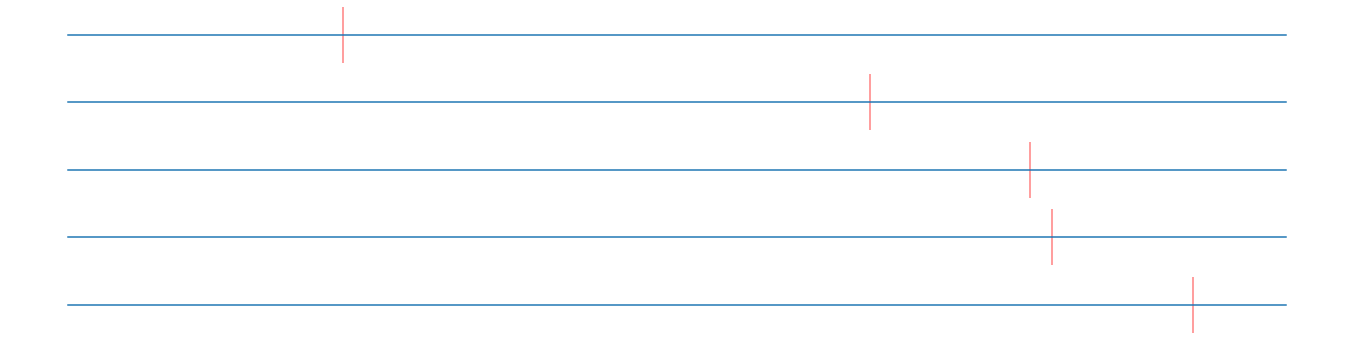

Training lstm ..
Rewards: [-0.92, -0.915, -0.92, 0.435, 0.46, -0.11, 0.53, -0.765, 0.345, -0.92, 0.51, 0.125, 0.365, 0.335, -0.72, -0.925, -0.89, -0.92, 0.53, -0.915]
lstm loss (epochs average): 0.0003706208132143729
NAS epoch 2
Epoch average accuracy (20 sequences): 0.615


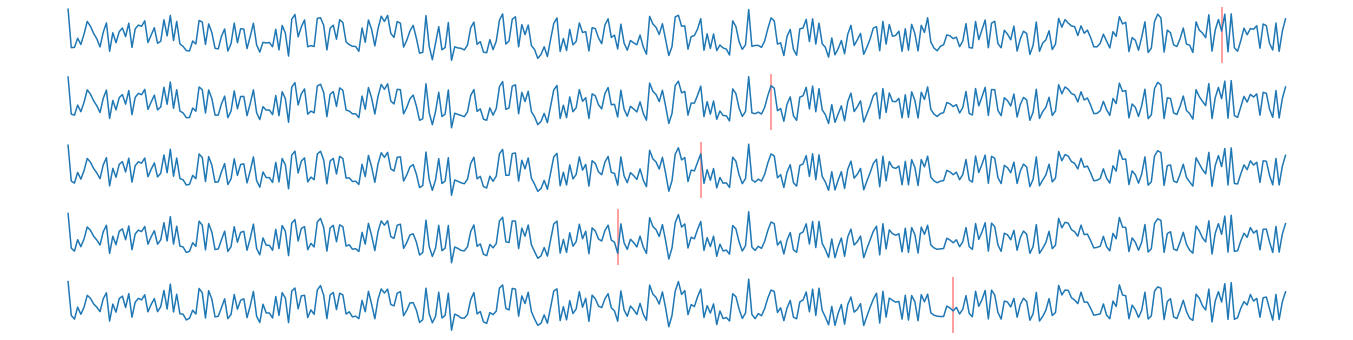

Training lstm ..
Rewards: [-0.92, -0.92, -0.65, 0.315, -0.865, -0.92, 0.54, 0.405, -0.925, 0.13, -0.92, -0.92, 0.5, -0.905, -0.92, -0.895, 0.365, 0.435, -0.49, -0.925]
lstm loss (epochs average): -5.796744517283514e-06
NAS epoch 3
Epoch average accuracy (20 sequences): 0.67


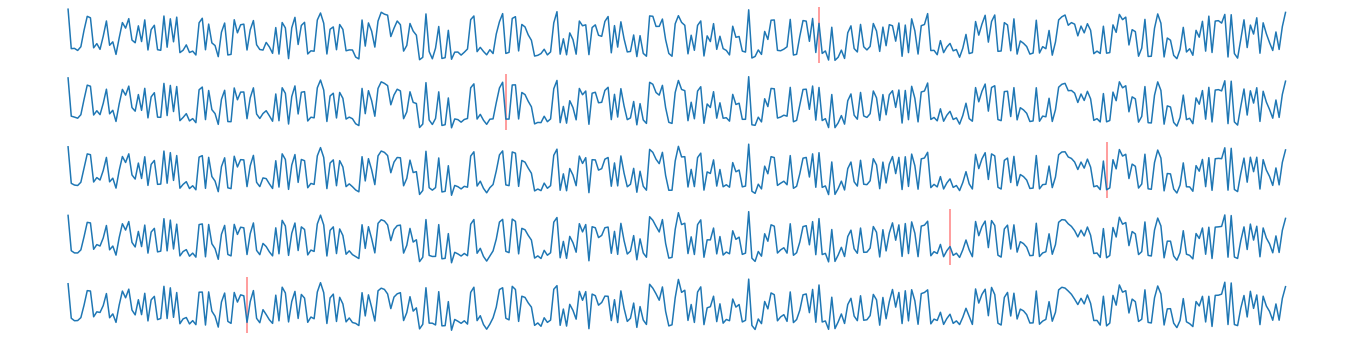

Training lstm ..
Rewards: [0.63, -0.92, -0.915, -0.92, -0.92, 0.57, -0.25, -0.89, -0.8, 0.58, 0.415, 0.525, 0.35, 0.41, -0.295, 0.52, 0.285, -0.885, -0.92, 0.475]
lstm loss (epochs average): 2.0502676989053725e-05
NAS epoch 4
Epoch average accuracy (20 sequences): 0.674


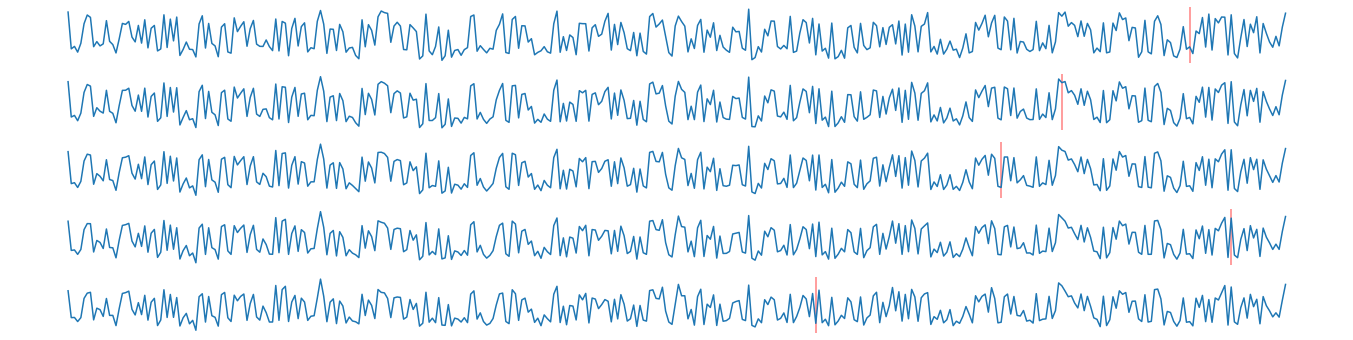

Training lstm ..
Rewards: [0.3, 0.485, 0.375, -0.925, 0.4, -0.92, -0.54, 0.4, -0.92, 0.455, 0.33, 0.53, -0.92, -0.92, -0.885, -0.925, 0.45, 0.425, -0.11, 0.335]
lstm loss (epochs average): 0.0006066447097055061
NAS epoch 5
Epoch average accuracy (20 sequences): 0.684


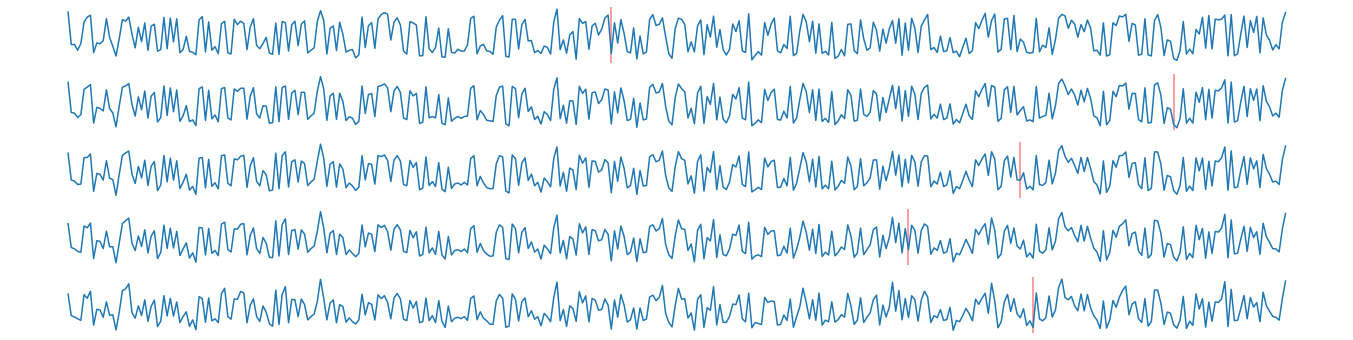

Training lstm ..
Rewards: [0.42, 0.39, -0.92, -0.92, -0.92, 0.49, -0.85, 0.465, 0.315, -0.08, 0.4, -0.88, 0.525, -0.915, 0.415, 0.385, 0.46, -0.025, 0.585, -0.92]
lstm loss (epochs average): 0.00024628165203921526
NAS epoch 6
Epoch average accuracy (20 sequences): 0.675


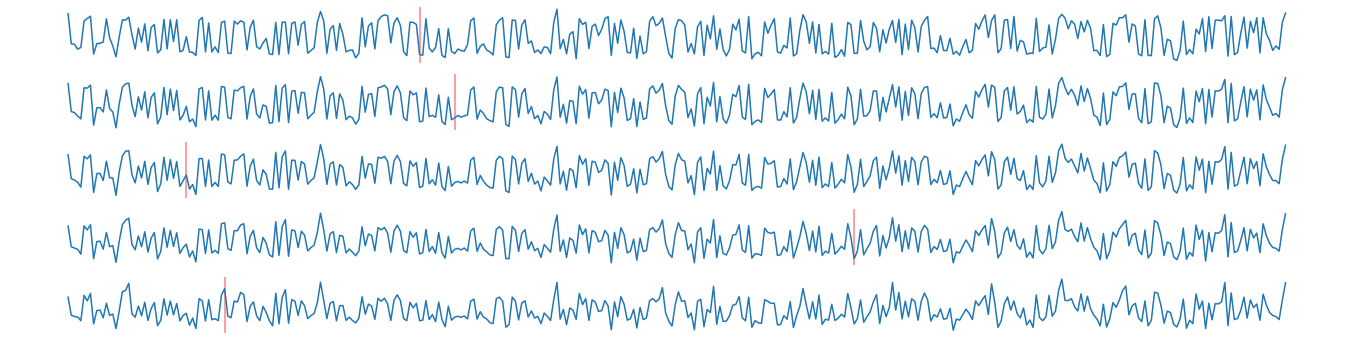

Training lstm ..
Rewards: [0.425, 0.355, 0.04, -0.92, 0.41, 0.615, 0.51, 0.41, 0.21, 0.425, -0.91, 0.5, -0.92, -0.915, -0.915, 0.33, -0.74, -0.915, -0.91, 0.455]
lstm loss (epochs average): 0.00027654997370518686
NAS epoch 7
Epoch average accuracy (20 sequences): 0.644


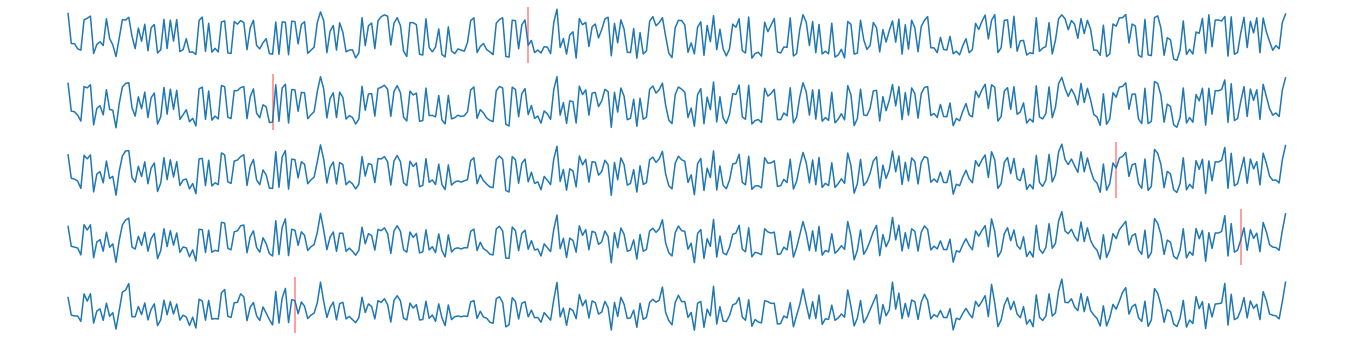

Training lstm ..
Rewards: [-0.92, -0.915, -0.92, -0.41, -0.575, -0.61, 0.6, 0.41, 0.34, 0.455, 0.255, -0.495, -0.915, 0.72, 0.47, 0.32, -0.925, -0.92, -0.625, -0.92]
lstm loss (epochs average): -0.0001697352466862867
NAS epoch 8
Epoch average accuracy (20 sequences): 0.673


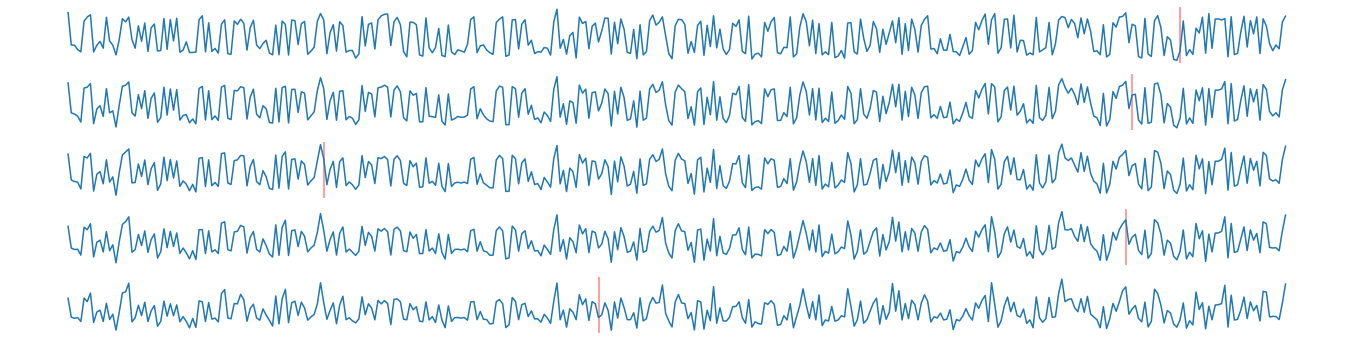

Training lstm ..
Rewards: [-0.92, 0.525, -0.92, 0.445, 0.465, 0.325, -0.43, 0.4, -0.92, 0.545, 0.445, -0.91, -0.895, 0.35, 0.34, 0.685, -0.915, 0.36, -0.795, -0.91]
lstm loss (epochs average): -0.0010976294336160208
NAS epoch 9
Epoch average accuracy (20 sequences): 0.633


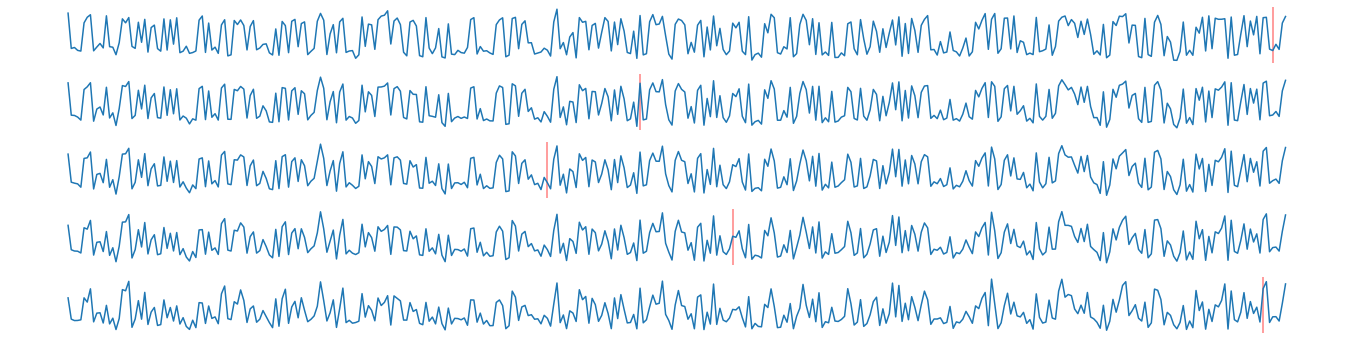

Training lstm ..
Rewards: [0.405, -0.895, -0.92, 0.64, 0.34, -0.915, -0.92, -0.425, -0.37, 0.425, 0.405, -0.915, -0.815, 0.315, 0.595, -0.83, -0.715, -0.925, -0.27, -0.91]
lstm loss (epochs average): -0.0007658474105483037
NAS epoch 10
Epoch average accuracy (20 sequences): 0.611


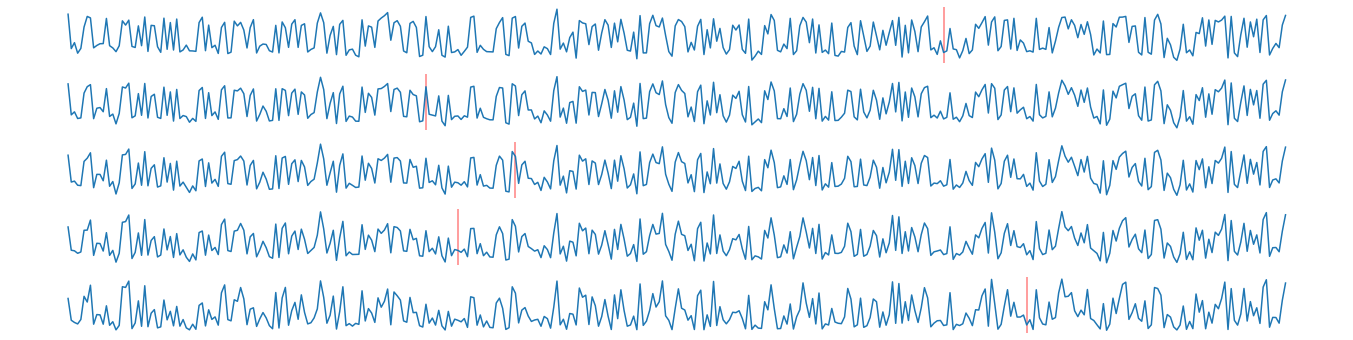

Training lstm ..
Rewards: [0.05, -0.92, -0.225, 0.45, 0.265, -0.92, -0.91, -0.92, -0.68, -0.92, -0.8, -0.925, 0.225, -0.925, 0.275, 0.335, -0.2, -0.82, -0.515, -0.815]
lstm loss (epochs average): 0.0008857128023009864
NAS epoch 11
Epoch average accuracy (20 sequences): 0.645


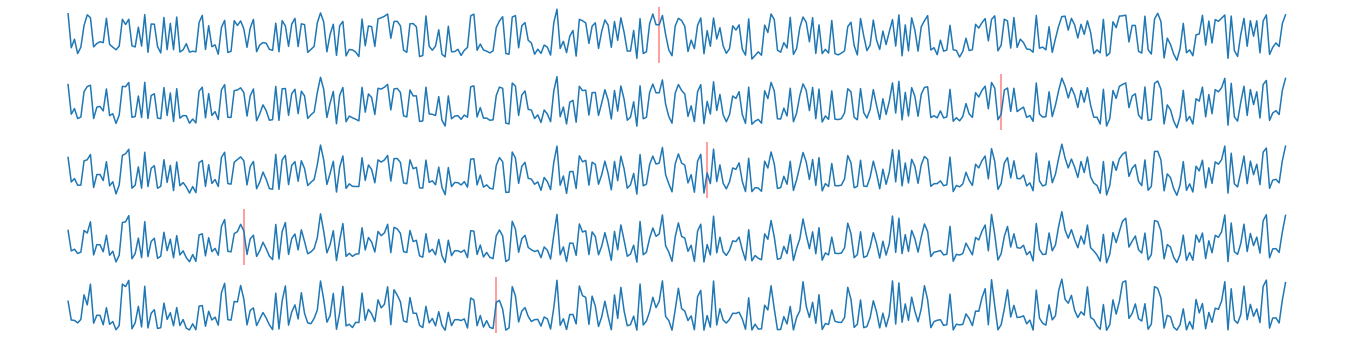

Training lstm ..
Rewards: [0.46, -0.915, 0.17, -0.255, -0.925, 0.315, 0.305, 0.385, -0.925, -0.925, 0.455, 0.46, 0.38, 0.04, -0.895, -0.915, -0.92, -0.91, -0.92, 0.05]
lstm loss (epochs average): 0.0008996517947252869
NAS epoch 12
Epoch average accuracy (20 sequences): 0.621


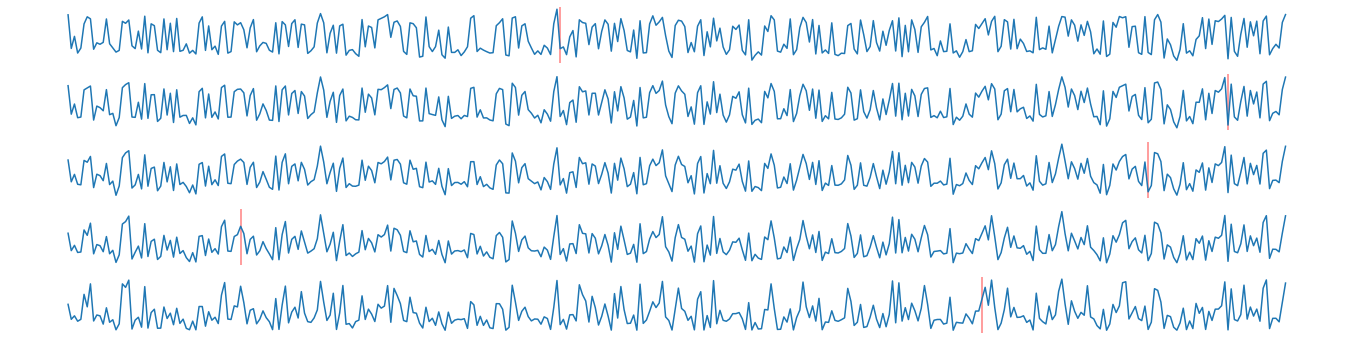

Training lstm ..
Rewards: [-0.925, -0.265, -0.915, -0.44, 0.49, -0.845, 0.5, -0.915, -0.485, -0.92, -0.925, -0.915, -0.125, 0.525, 0.525, -0.915, 0.555, -0.925, -0.09, -0.925]
lstm loss (epochs average): -0.00010004014279729745
NAS epoch 13
Epoch average accuracy (20 sequences): 0.637


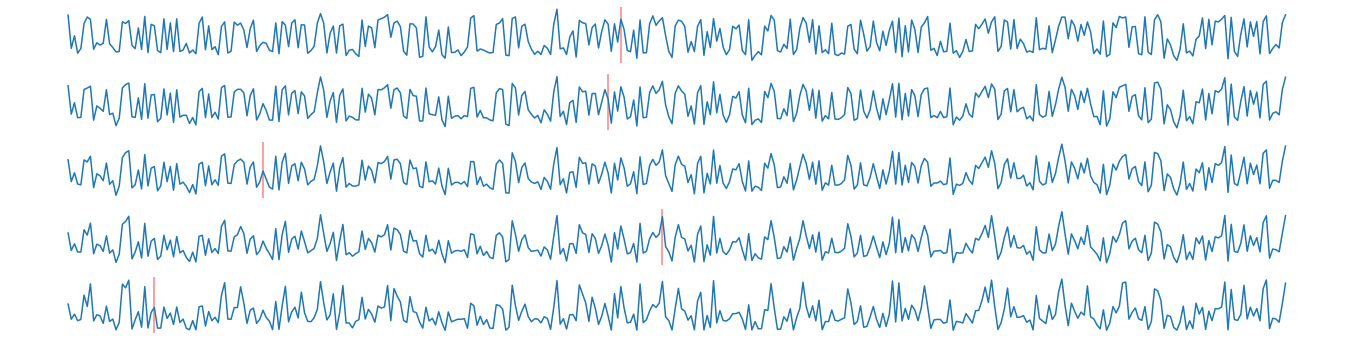

Training lstm ..
Rewards: [-0.92, 0.37, 0.58, -0.92, 0.31, -0.915, -0.915, -0.92, -0.915, -0.925, -0.745, 0.355, -0.095, 0.485, -0.925, -0.92, -0.63, 0.48, 0.525, 0.35]
lstm loss (epochs average): 7.0084957542349e-05
NAS epoch 14
Epoch average accuracy (20 sequences): 0.649


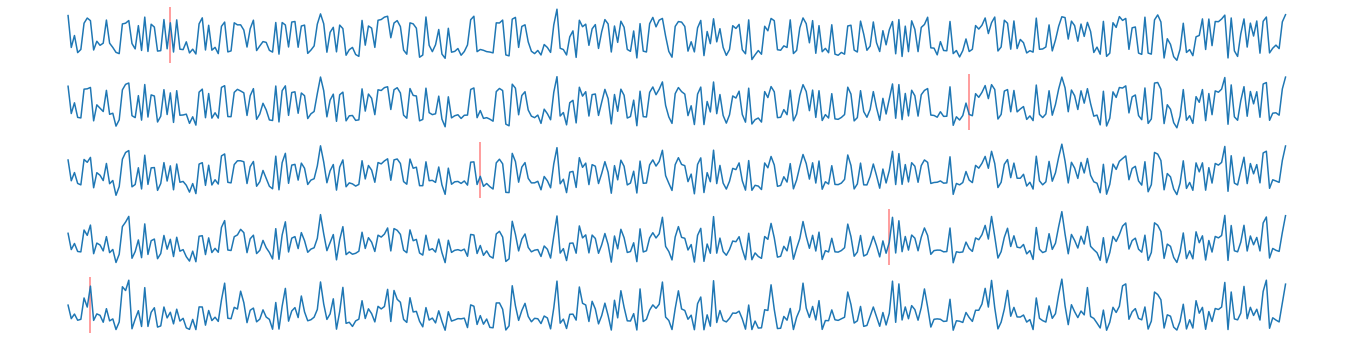

Training lstm ..
Rewards: [-0.475, -0.92, 0.38, 0.48, -0.92, -0.13, -0.92, -0.925, 0.52, -0.73, -0.615, 0.52, -0.92, -0.3, -0.91, 0.375, 0.435, -0.885, 0.555, 0.325]
lstm loss (epochs average): 0.00025747250009544587
NAS epoch 15
Epoch average accuracy (20 sequences): 0.694


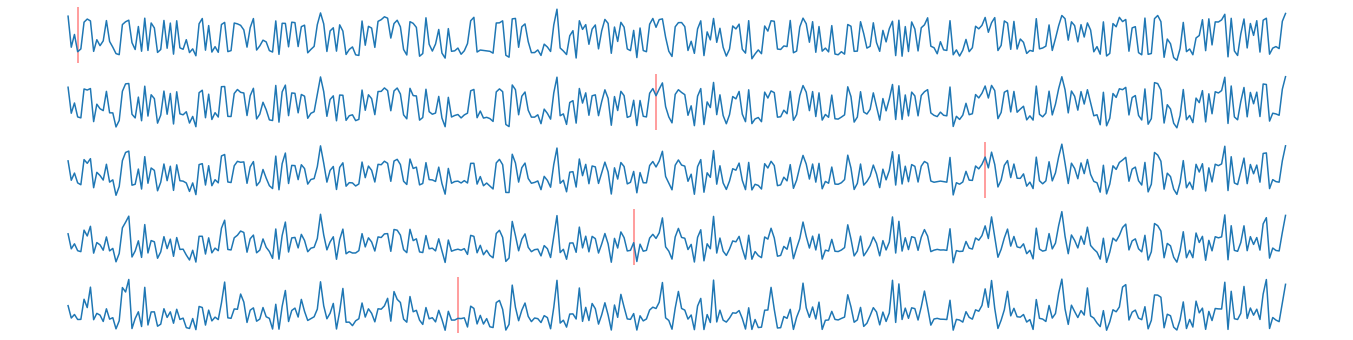

Training lstm ..
Rewards: [-0.52, 0.885, 0.105, 0.07, -0.855, 0.14, 0.45, 0.115, 0.46, -0.8, 0.665, 0.53, -0.8, -0.915, -0.92, -0.92, 0.65, 0.055, 0.64, 0.39]
lstm loss (epochs average): 0.0001872597000085463
NAS epoch 16
Epoch average accuracy (20 sequences): 0.706


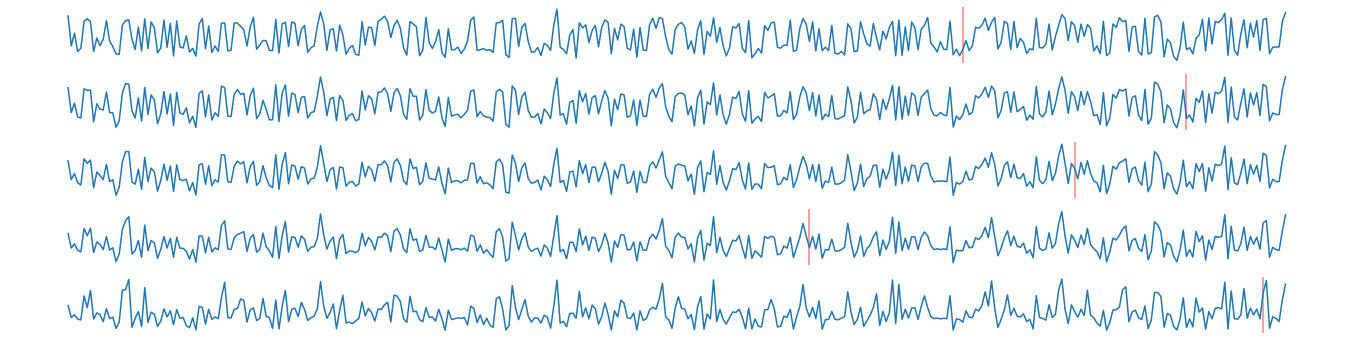

Training lstm ..
Rewards: [-0.92, 0.435, -0.105, -0.055, 0.455, -0.245, 0.555, -0.46, 0.505, 0.575, -0.92, 0.52, 0.4, 0.39, 0.52, -0.905, 0.505, -0.18, 0.465, -0.925]
lstm loss (epochs average): 0.00011806948424464281
NAS epoch 17
Epoch average accuracy (20 sequences): 0.655


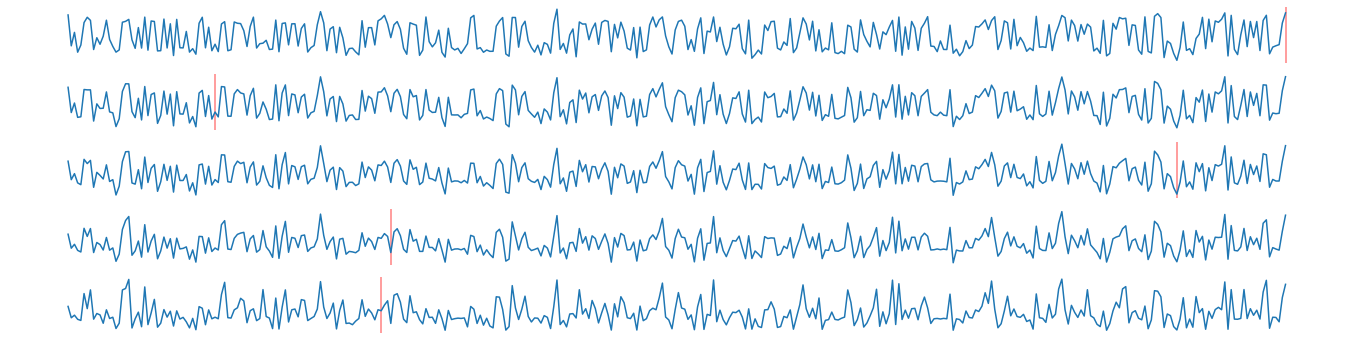

Training lstm ..
Rewards: [-0.92, -0.535, -0.35, 0.485, 0.345, 0.415, -0.925, -0.92, -0.905, 0.3, -0.915, 0.425, -0.925, -0.495, 0.435, -0.915, 0.52, 0.49, -0.51, 0.415]
lstm loss (epochs average): 5.211315928477234e-05
NAS epoch 18
Epoch average accuracy (20 sequences): 0.677


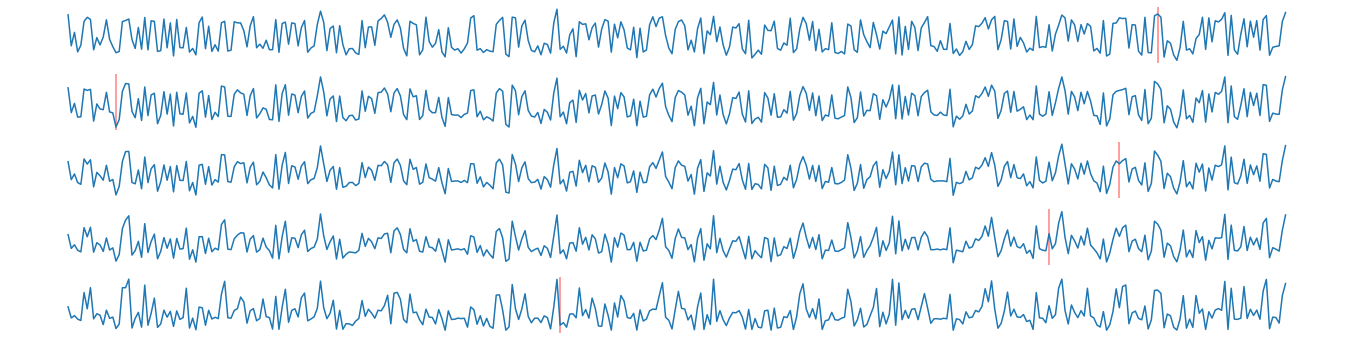

Training lstm ..
Rewards: [0.395, 0.29, 0.37, 0.47, 0.475, -0.75, 0.395, 0.675, 0.415, -0.925, -0.475, 0.225, -0.185, -0.765, -0.925, -0.925, -0.91, -0.595, 0.35, 0.105]
lstm loss (epochs average): -0.00012091350799892098
NAS epoch 19
Epoch average accuracy (20 sequences): 0.658


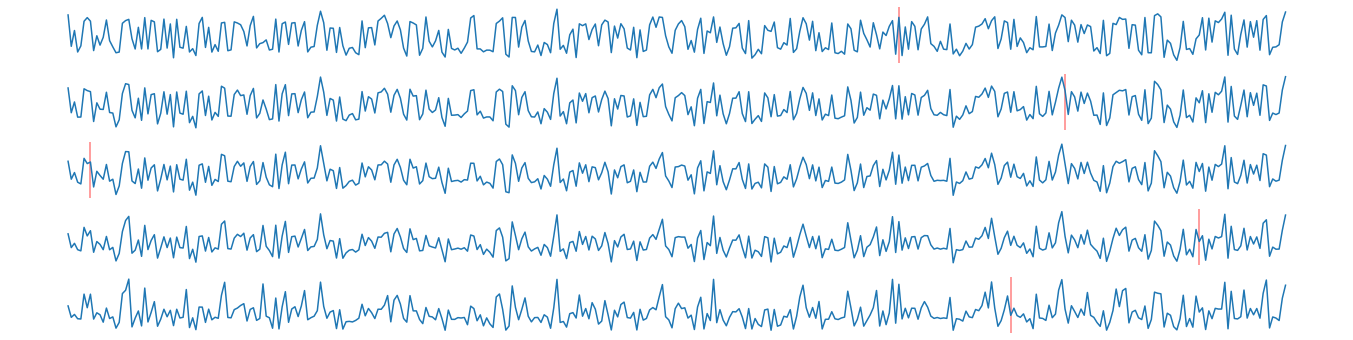

Training lstm ..
Rewards: [0.42, 0.575, 0.36, -0.92, 0.405, -0.92, -0.925, 0.155, -0.92, -0.755, 0.32, 0.4, -0.915, -0.69, 0.425, -0.92, -0.38, 0.51, 0.485, -0.86]
lstm loss (epochs average): 0.00013982482937535679
NAS epoch 20
Epoch average accuracy (20 sequences): 0.688


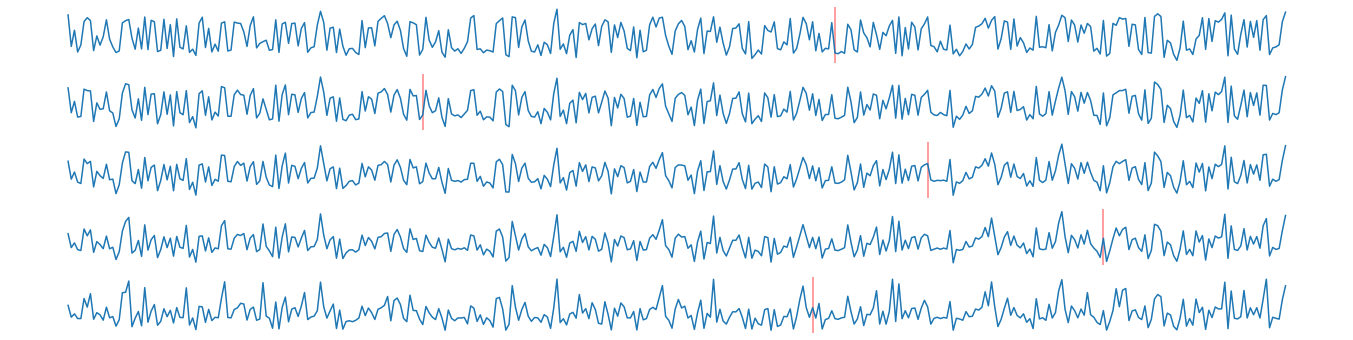

Training lstm ..
Rewards: [0.475, 0.4, 0.435, 0.575, -0.81, 0.645, 0.465, 0.375, 0.49, -0.675, -0.3, -0.78, -0.28, -0.905, -0.925, -0.89, 0.58, 0.265, 0.42, -0.8]
lstm loss (epochs average): 0.00014109666858530545
NAS epoch 21
Epoch average accuracy (20 sequences): 0.645


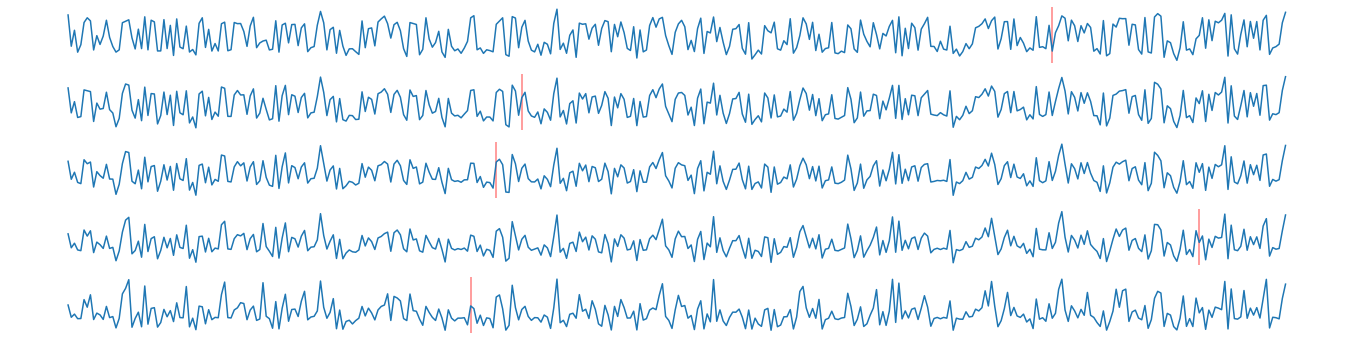

Training lstm ..
Rewards: [-0.89, 0.47, 0.365, -0.92, 0.4, -0.92, 0.335, 0.5, -0.92, 0.505, 0.56, -0.92, -0.85, 0.3, 0.395, -0.74, -0.915, -0.925, -0.915, -0.4]
lstm loss (epochs average): -4.997852204269293e-05
NAS epoch 22
Epoch average accuracy (20 sequences): 0.679


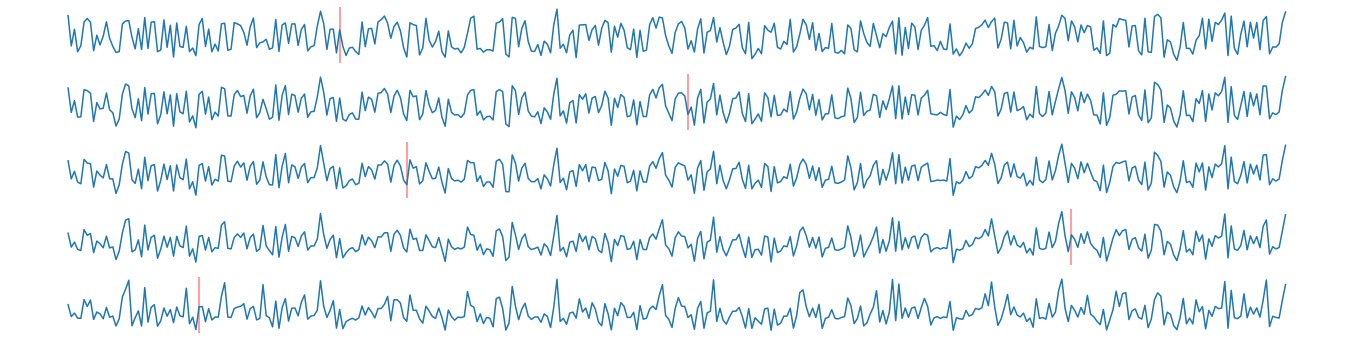

Training lstm ..
Rewards: [0.345, 0.095, -0.92, -0.925, 0.5, 0.445, 0.615, -0.885, 0.48, 0.465, 0.445, 0.285, -0.895, 0.335, 0.375, -0.915, -0.63, -0.915, -0.72, 0.27]
lstm loss (epochs average): 9.3374198257834e-05
NAS epoch 23
Epoch average accuracy (20 sequences): 0.701


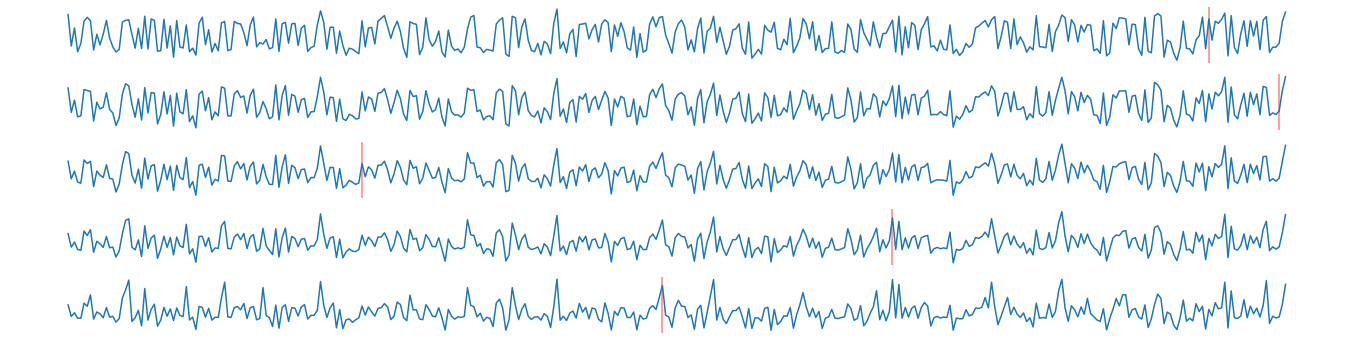

Training lstm ..
Rewards: [0.075, 0.495, 0.525, 0.45, 0.66, -0.905, -0.25, 0.685, 0.48, 0.565, -0.015, 0.42, -0.92, -0.925, 0.245, 0.405, 0.48, -0.875, -0.915, -0.545]
lstm loss (epochs average): -0.00011438819444720139
NAS epoch 24
Epoch average accuracy (20 sequences): 0.724


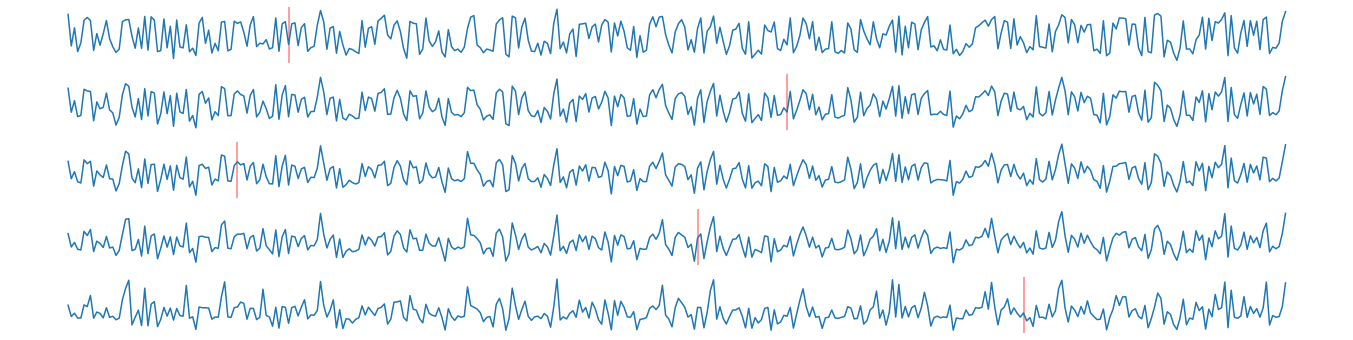

Training lstm ..
Rewards: [-0.925, -0.92, 0.585, -0.915, -0.92, 0.31, 0.61, 0.51, 0.435, -0.92, 0.5, 0.32, 0.43, 0.465, 0.405, 0.51, 0.355, 0.48, 0.425, 0.615]
lstm loss (epochs average): -0.0004149112492086715
NAS epoch 25
Epoch average accuracy (20 sequences): 0.681


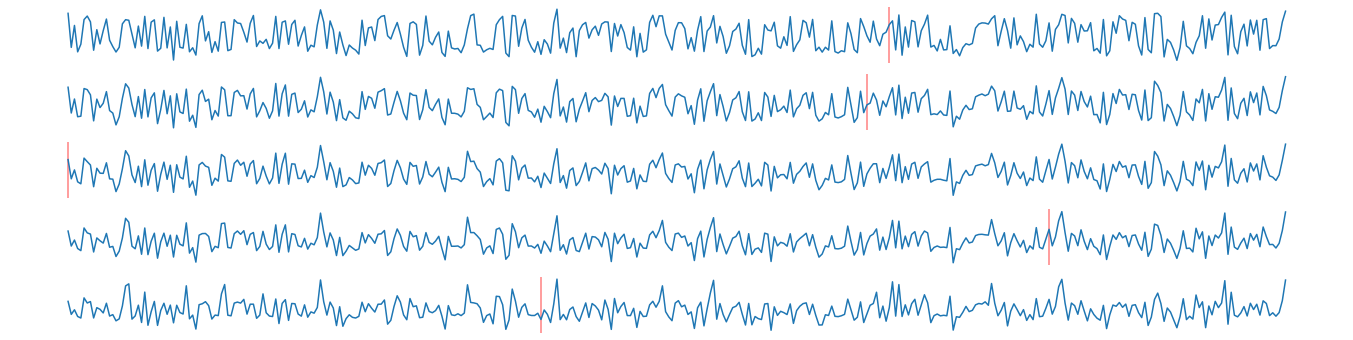

Training lstm ..
Rewards: [-0.02, 0.52, -0.875, 0.455, 0.535, -0.48, 0.395, 0.27, 0.515, 0.56, -0.915, -0.915, -0.905, 0.45, -0.925, 0.385, 0.47, 0.38, -0.85, -0.925]
lstm loss (epochs average): 2.5877636403492943e-05
NAS epoch 26
Epoch average accuracy (20 sequences): 0.633


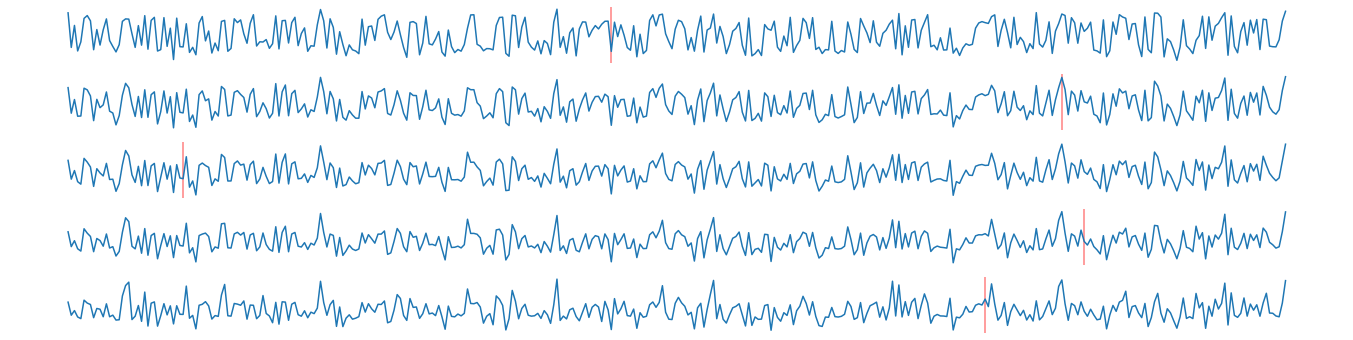

Training lstm ..
Rewards: [-0.915, -0.875, 0.285, -0.92, -0.85, 0.47, -0.92, -0.925, 0.465, 0.335, -0.92, 0.465, 0.02, 0.5, -0.915, -0.92, 0.465, 0.3, -0.92, -0.92]
lstm loss (epochs average): -0.0001506897112903971
NAS epoch 27
Epoch average accuracy (20 sequences): 0.668


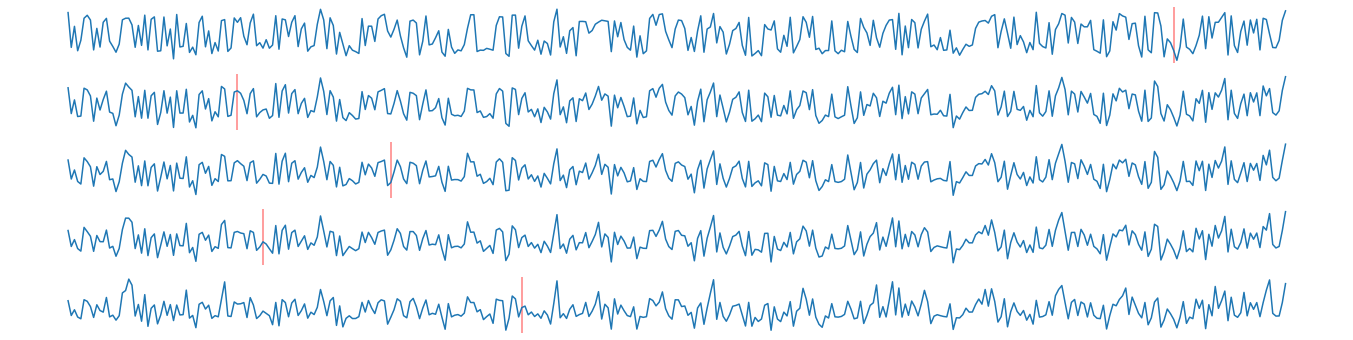

Training lstm ..
Rewards: [-0.925, -0.89, -0.8, 0.19, -0.09, -0.885, 0.43, 0.075, 0.56, -0.895, 0.465, -0.12, -0.91, 0.465, -0.915, 0.45, 0.575, -0.775, 0.32, 0.465]
lstm loss (epochs average): 0.00022609210992641238
NAS epoch 28
Epoch average accuracy (20 sequences): 0.662


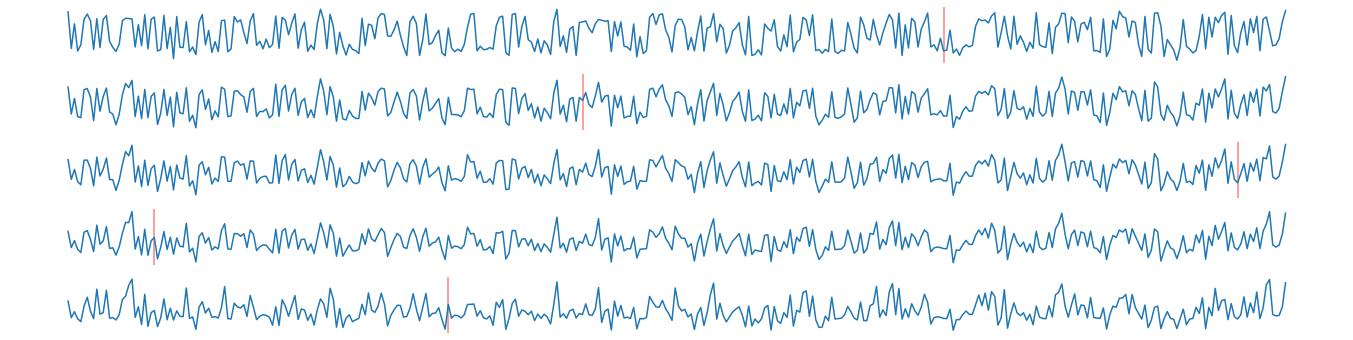

Training lstm ..
Rewards: [-0.925, -0.915, 0.265, -0.555, -0.9, 0.325, 0.495, 0.39, 0.525, 0.48, 0.34, -0.92, 0.41, 0.44, -0.64, -0.355, -0.755, -0.915, 0.365, -0.92]
lstm loss (epochs average): -0.00032062949946976005
NAS epoch 29
Epoch average accuracy (20 sequences): 0.73


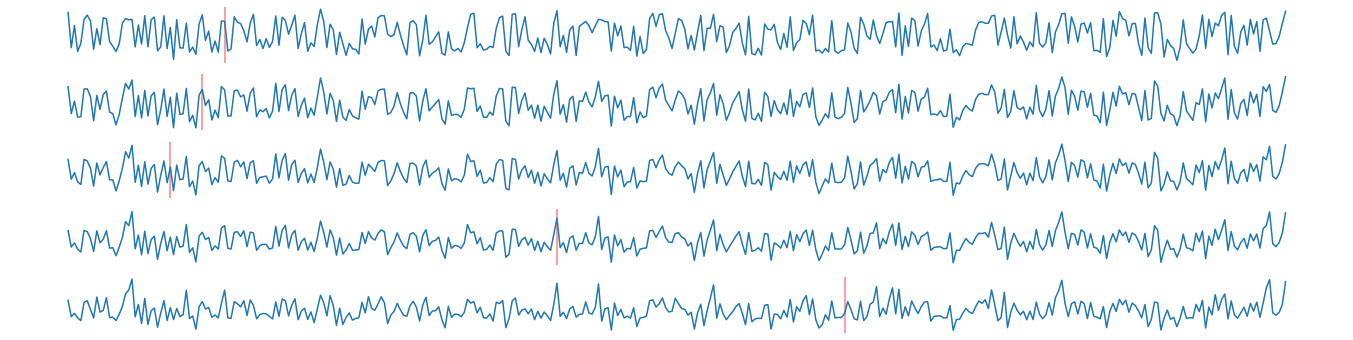

Training lstm ..
Rewards: [0.49, 0.18, 0.05, -0.47, 0.335, -0.92, 0.61, 0.395, 0.485, -0.185, -0.24, 0.745, 0.56, 0.49, 0.545, -0.91, 0.19, -0.37, 0.57, 0.4]
lstm loss (epochs average): 0.00022673120383842615
NAS epoch 30
Epoch average accuracy (20 sequences): 0.656


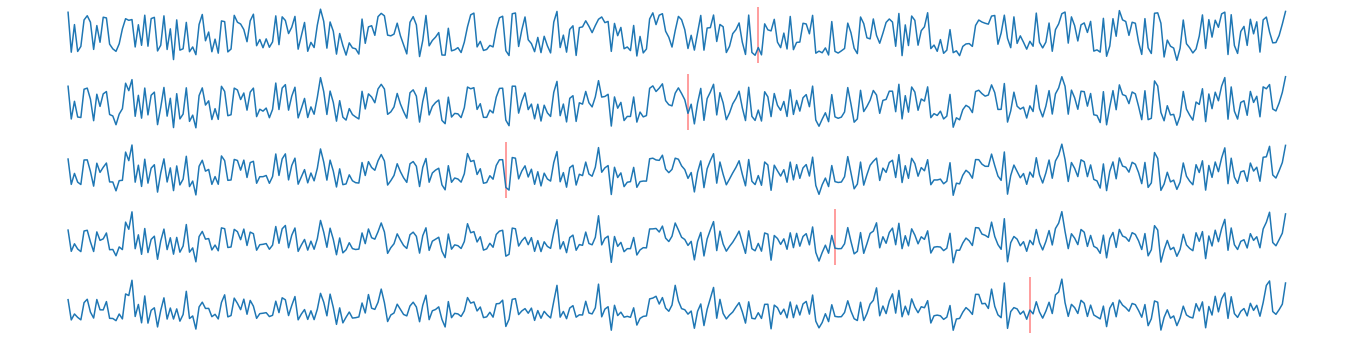

Training lstm ..
Rewards: [-0.92, 0.075, 0.49, 0.31, -0.925, 0.725, -0.915, 0.4, 0.265, -0.765, -0.92, -0.17, 0.485, -0.88, 0.475, -0.13, -0.905, -0.92, -0.765, 0.565]
lstm loss (epochs average): 1.1369791536708362e-05
Done.


In [13]:
history_data_x = []
history_data_acc = []
history_lstm_loss = []
history_avg_acc = []
history_rewards = []

for nas_epoch in range(no_of_nas_epochs):
    sequences = []
    data_x = None
    accuracies = []
    data_acc = None
    print("NAS epoch", nas_epoch+1)
    sample_seq = 0
    while sample_seq < no_of_samples_per_epoch:
        sequence = np.zeros((1, max_no_of_layers-1, no_of_layer_params), dtype="int32")
        distribution = model.predict(sequence)
        selected_ = []
        for prob in distribution[0]:
            selected_.append(np.random.choice(search_space, size=1, p=prob)[0])

        selected_expanded = expand_token([int(i) for i in selected_])
        sequence = np.array(selected_expanded)[np.newaxis]
        
#         last_layer = np.array(expand_token([int(search_space[-1])]))[np.newaxis]
#         sequence = np.hstack([sequence, last_layer])
        if not any(np.array_equal(sequence, x) for x in sequences):
            sequences.append(sequence)
            sequence_acc = performance_estimate([int(i) for i in selected_] + [int(search_space[-1])])
            accuracies.append(sequence_acc)
            sample_seq += 1

        data_acc = np.vstack(accuracies)
    
    avg_acc = round(np.average(accuracies),3)
    print(f"Epoch average accuracy ({no_of_samples_per_epoch} sequences):", avg_acc)
#     baseline = avg_acc + 0.05
    plot_distribution(search_space, distribution[0], selected_)
    print("Training lstm ..")
    rewards_ = (rew_coef * (data_acc - baseline)).tolist()
    print("Rewards:", [round(i[0], 4) for i in rewards_])
    data_x = np.array(sequences).reshape(len(sequences), max_no_of_layers-1, no_of_layer_params)
    data_y = to_categorical(data_x, len(search_space)+1)
    history = model.fit({'main_input': data_x},
                        {'main_output': data_y},
                        epochs=rnn_train_epochs,
                        batch_size=len(data_x),
                        verbose=0)
    lstm_loss_avg = np.average(list(history.history.values())[0])
    print("lstm loss (epochs average):", lstm_loss_avg)
    
    history_avg_acc.append(avg_acc)
    history_lstm_loss.append(lstm_loss_avg)
    history_data_x.append(data_x)
    history_data_acc.append(data_acc)   
    history_rewards.append(rewards_) 
print("Done.")

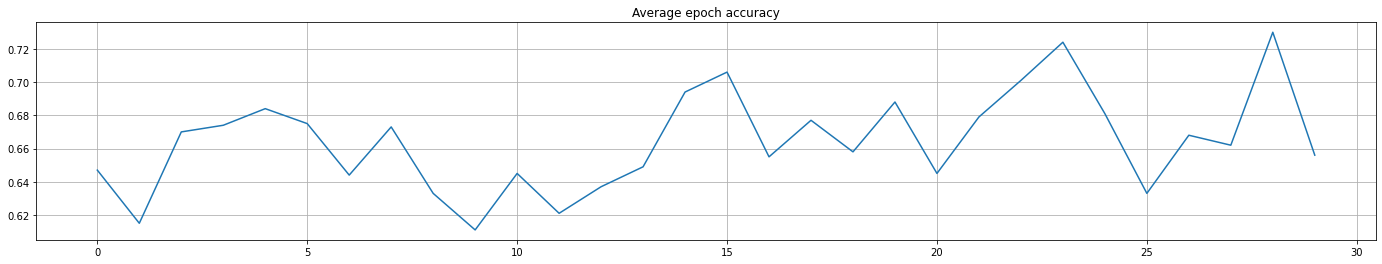

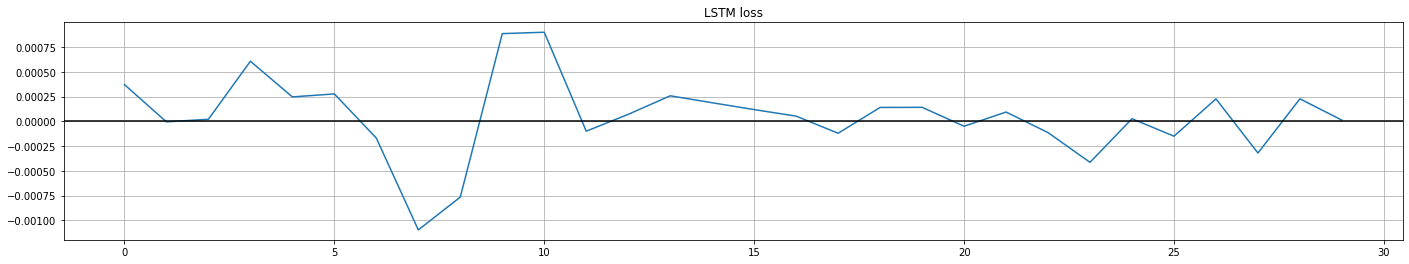

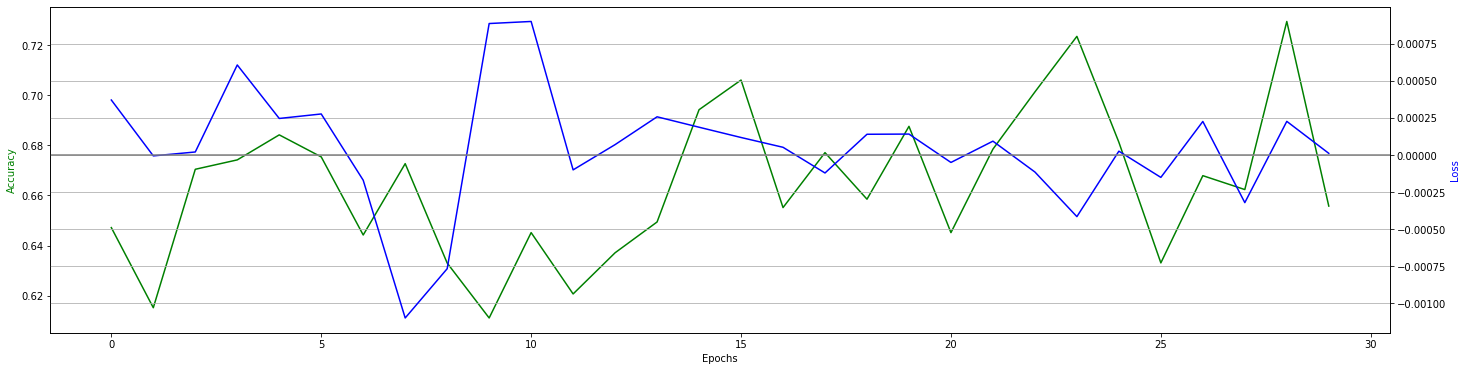

In [14]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_avg_acc)), history_avg_acc)
plt.title("Average epoch accuracy")
plt.grid()
plt.show()
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss)
plt.title("LSTM loss")
plt.axhline(y=0, c="k")
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(24, 6))
ax2 = ax1.twinx()

all_acc_avg = [[np.average(i)] for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]

ax1.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, c="g")
ax2.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss, c="b")
ax2.axhline(y=0, c="gray")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color='g')
ax2.set_ylabel("Loss", color='b')
plt.grid()
plt.show()

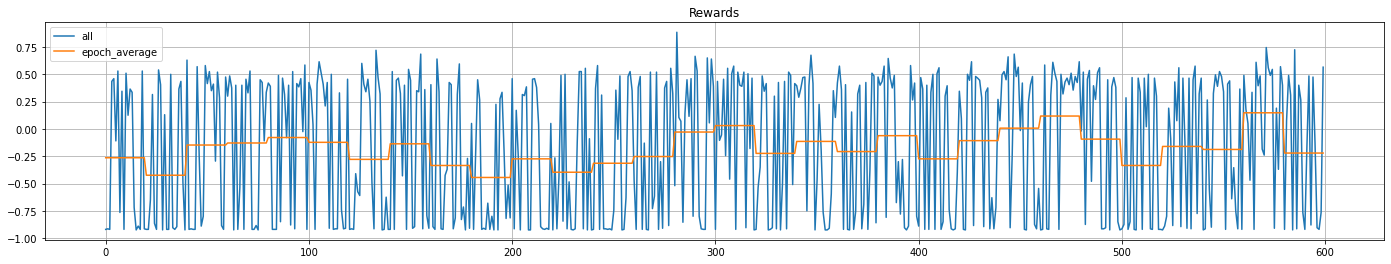

In [15]:
fig = plt.figure(figsize=(24, 4))
all_rew = np.array(history_rewards)
all_rew = all_rew.reshape(all_rew.shape[0]*all_rew.shape[1],1)

rewards_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_rewards]
rewards_avg = [item for sublist in rewards_avg for item in sublist]

plt.plot(np.arange(0,len(all_rew)), all_rew, label="all")
plt.plot(np.arange(0,len(rewards_avg)), rewards_avg, label="epoch_average")
plt.title("Rewards")
plt.legend()
plt.grid()
plt.show()

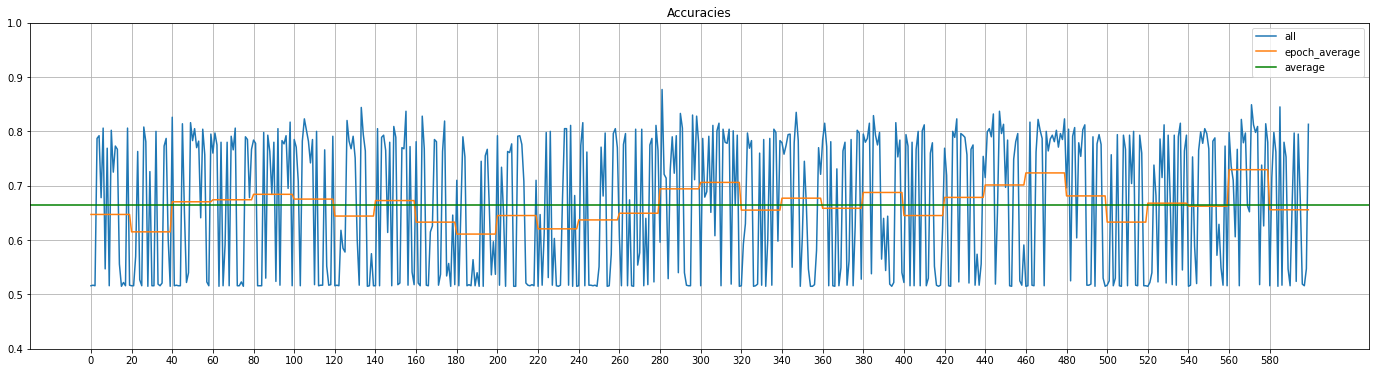

Total accuracy average: 0.6645617
Best accuracy: 0.877


In [16]:
fig = plt.figure(figsize=(24, 6))
all_acc = np.array(history_data_acc)
all_acc = all_acc.reshape(all_acc.shape[0]*all_acc.shape[1],1)
plt.plot(np.arange(0,len(all_acc)), all_acc, label="all")

all_acc_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]
plt.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, label="epoch_average")

# plt.axhline(y=baseline, c="r", label="baseline")
plt.axhline(y=np.average(all_acc), c="g", label="average")
plt.title("Accuracies")
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.ylim([0.4,1])
plt.grid()
plt.legend()
plt.show()
print("Total accuracy average:", np.average(all_acc))
print("Best accuracy:", np.max(all_acc))

In [17]:
# random_acc = []
# for i in range(len(all_acc)):
#     random_acc.append(performance_estimate(np.random.randint(low=1, high=len(search_space), size=max_no_of_layers)))

# fig = plt.figure(figsize=(24, 6))
# plt.plot(np.arange(0,len(random_acc)), random_acc)
# plt.ylim([0,1])
# plt.grid()
# plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
# plt.axhline(y=baseline, c="r")
# plt.axhline(y=np.average(random_acc), c="g")
# plt.title("Random")
# plt.show()
# print(np.average(random_acc))